In [6]:
from matplotlib import pyplot as plt
import os
import numpy as np
import seaborn as sns

In [150]:

class Args:
    def __init__(self):
        self.log_root='log/'
        self.dataset = 'naval'

        self.train_bias_y = False
        self.train_bias_f = False
        self.train_cons = False
        self.train_calib = False
        self.re_calib = False
        self.re_bias_f = False
        self.re_bias_y = False

        # Modeling parameters
        self.model = 'linear'
        self.learning_rate = 1e-3
        self.batch_size = 32
        self.bbatch_size = 1024
        self.num_bins = 0
        self.knn = 100

        # Run related parameters
        self.gpu = 0
        self.num_epoch = 500
        self.run_label = 0
        self.num_run = 10


In [151]:
models = ['linear', 'small', 'med', 'big']

In [152]:
num_rep = 3
# num_runs = list(range(24)) + list(range(40, 40+24))
max_runs = 10
fps = np.zeros((len(models), 13, max_runs * num_rep, 8))
fns = np.zeros((len(models), 13, max_runs * num_rep, 8))
objectives = np.zeros((len(models), 13, max_runs * num_rep, 5))


In [125]:
num_runs = list(range(100, 115))
for objective in range(8):
    args = Args()
    if objective % 2 == 1:
        args.train_bias_f = True
    if (objective // 2) % 2 == 1:
        args.train_bias_y = True
    if objective // 4 == 1:
        args.train_calib = True
    
    for run_i, run_label in enumerate(num_runs):
        args.run_label = run_label
        args.name = '%s/model=%s-%r-%r-%r-%r-%r-%r-%r-bs=%d-%d-bin=%d-%d-run=%d' % \
            (args.dataset, args.model, 
             args.train_bias_y, args.train_bias_f, args.train_cons, args.train_calib, args.re_calib, args.re_bias_f, args.re_bias_y,
             args.batch_size, args.bbatch_size, args.num_bins, args.knn, args.run_label)
        log_dir = os.path.join(args.log_root, args.name)
        reader = open(os.path.join(log_dir, 'results.txt'))
        for epoch in range(5):
            reader.readline()
        for rep in range(num_rep):
            line = reader.readline().split()
            objectives[objective, run_i*num_rep+rep] = np.array([float(line[i]) for i in range(5)])
            fnfp = np.reshape(np.array([float(line[i]) for i in range(5, 21)]), [-1, 2])
            fns[objective, run_i*num_rep+rep] = fnfp[:, 0]
            fps[objective, run_i*num_rep+rep] = fnfp[:, 1]
            #for epoch in range(1):
            #    reader.readline()
            

FileNotFoundError: [Errno 2] No such file or directory: 'log/protein/model=linear-False-False-False-False-False-False-False-bs=32-1024-bin=0-100-run=100/results.txt'

In [153]:
num_rep = 3
max_line = 1000000
# num_runs = list(range(24)) + list(range(40, 40+24))
num_runs = list(range(10, 20))
labels = ['none', 'calib', 'bias f', 'bias_y', 'all']
for m_id, model in enumerate(models):
    for objective in range(5):
        args = Args()
        args.model = model
        if objective == 1:
            args.re_calib = True
        if objective == 2:
            args.re_bias_f = True
        if objective == 3:
            args.re_bias_y = True
        if objective == 4:
            args.re_calib = True
            args.re_bias_f = True
            args.re_bias_y = True

        for run_i, run_label in enumerate(num_runs):
            args.run_label = run_label
            args.name = '%s/model=%s-%r-%r-%r-%r-%r-%r-%r-bs=%d-%d-bin=%d-%d-run=%d' % \
                (args.dataset, args.model, 
                 args.train_bias_y, args.train_bias_f, args.train_cons, args.train_calib, args.re_calib, args.re_bias_f, args.re_bias_y,
                 args.batch_size, args.bbatch_size, args.num_bins, args.knn, args.run_label)
            log_dir = os.path.join(args.log_root, args.name)
            reader = open(os.path.join(log_dir, 'results.txt'))

            cur_rep = 0
            for line_id in range(max_line):
                line = reader.readline().split()
                if len(line) < 21:
                    # print("%s-%d-%d-%d" % (model, objective, run_i, line_id))
                    break
                objectives[m_id, objective+8, run_i*num_rep+cur_rep] = np.array([float(line[i]) for i in range(5)])
                fnfp = np.reshape(np.array([float(line[i]) for i in range(5, 21)]), [-1, 2])
                fns[m_id, objective+8, run_i*num_rep+cur_rep] = fnfp[:, 0]
                fps[m_id, objective+8, run_i*num_rep+cur_rep] = fnfp[:, 1]
                if line_id % 10 == 0:
                    cur_rep = (cur_rep + 1) % num_rep

                #for epoch in range(1):
                #    reader.readline()


In [154]:
from sklearn.isotonic import IsotonicRegression

/atlas/u/shengjia/env3/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


IndexError: index 4 is out of bounds for axis 0 with size 4

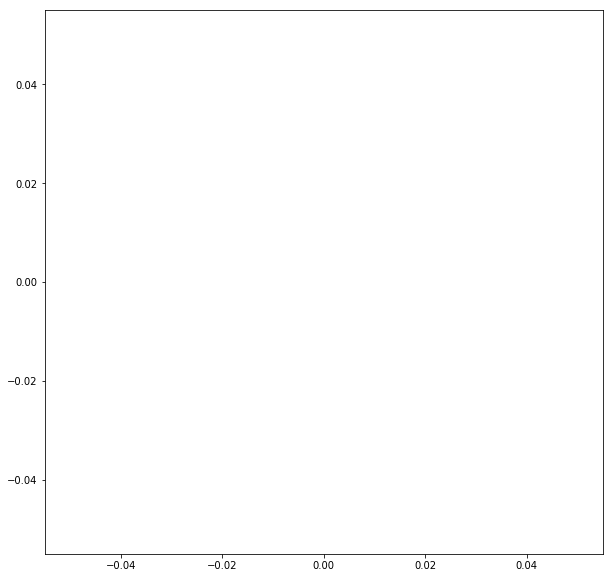

In [155]:
plt.figure(figsize=(10, 10))
palette = sns.color_palette('husl', 5)
for i in range(8):
    # plt.scatter(fns[i].flatten(), fps[i].flatten(), alpha=0.5, color=palette[i] , label=names[i])
    
    # iso_reg = IsotonicRegression(increasing=False).fit(fns[i].flatten(), fps[i].flatten())
    # new_fn = np.linspace(np.min(fns[i]), np.max(fns[i]), 1000)
    # plt.plot(new_fn, iso_reg.predict(new_fn), color=palette[i], linestyle='-.')
    
    # iso_reg = IsotonicRegression(increasing=False).fit(fps[i].flatten(), fns[i].flatten())
    # new_fp = np.linspace(np.min(fps[i]), np.max(fps[i]), 1000)
    # plt.plot(iso_reg.predict(new_fp), new_fp, color=palette[i], linestyle=':')
    
    resolution = 100
    fnfp = np.stack([fns[i].flatten(), fps[i].flatten()], axis=-1)
    fnfp_norm = fnfp / np.linalg.norm(fnfp, 2, axis=-1, keepdims=True)
    center = np.stack([np.linspace(0.0, 1.0, 100), np.linspace(1.0, 0.0, 100)], axis=-1)
    center /= np.linalg.norm(center, 2, axis=-1, keepdims=True)
    
    avg = np.zeros(resolution)
    for k in range(resolution):
        cos_dis = np.argsort(np.sum(fnfp_norm * center[k:k+1], axis=-1))
        avg[k] = np.mean(np.sum(fnfp * center[k:k+1], axis=-1)[cos_dis[-40:]])
    
    vals = center * np.reshape(avg, (-1, 1))
    plt.plot(vals[:, 0], vals[:, 1], color=palette[i], label=bin(i))
    
    
plt.legend()
plt.savefig('result.png')
plt.show()

(4, 13, 30, 5)


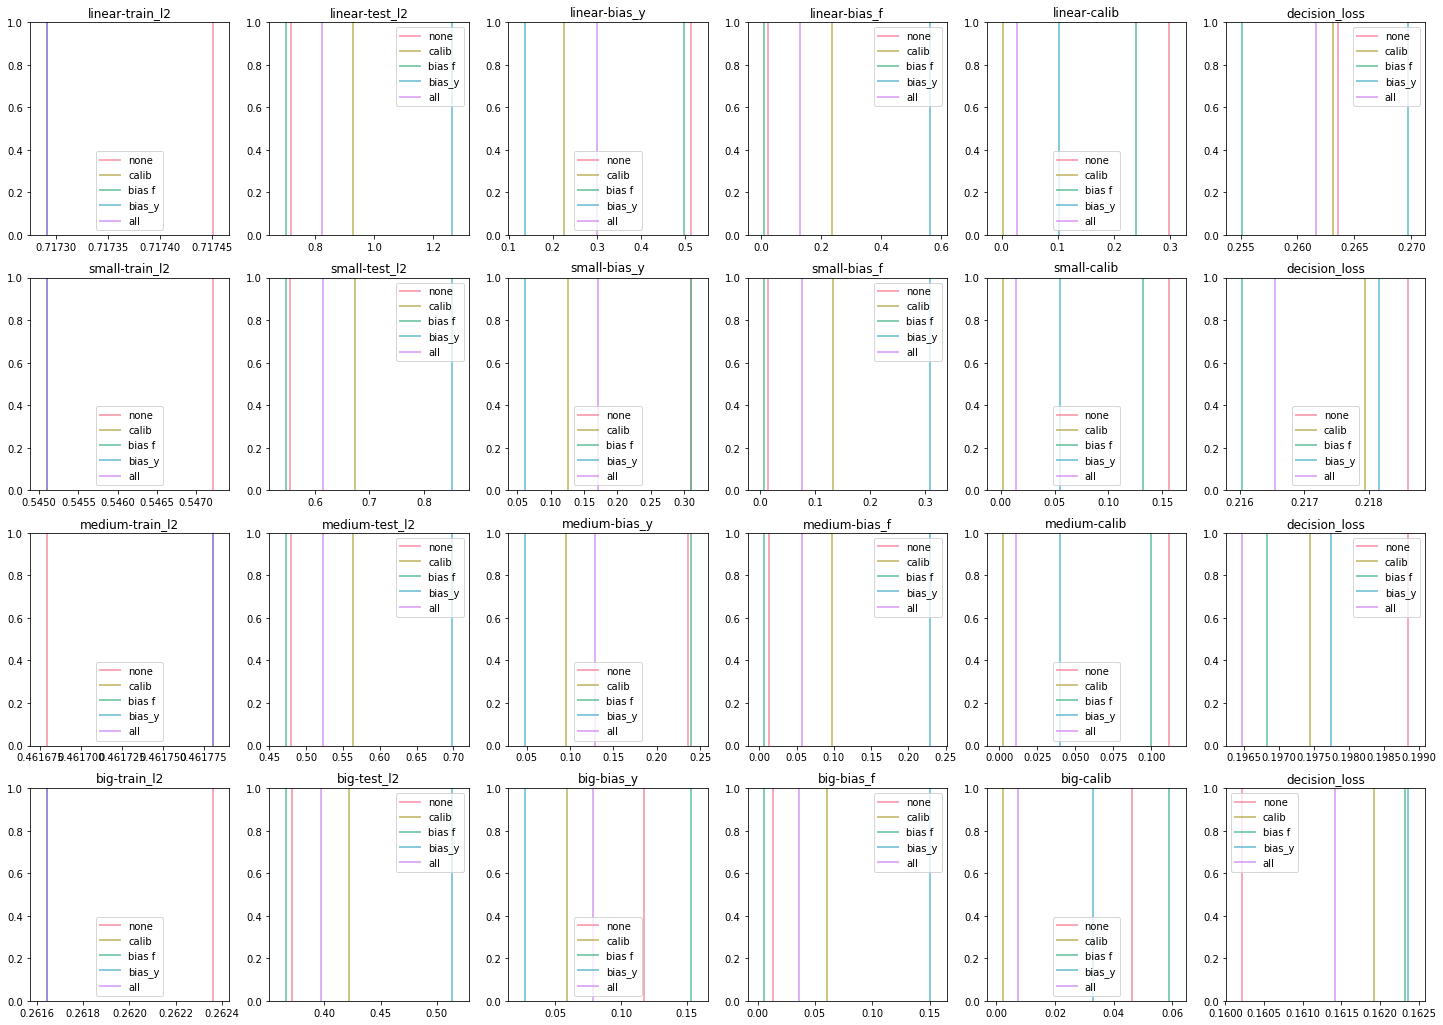

In [130]:
print(objectives.shape)
palette = sns.color_palette('husl', 5)
plt.figure(figsize=(25, 4.5*len(models)))
for mid, model in enumerate(models):
    names = ['train_l2', 'test_l2', 'bias_y', 'bias_f', 'calib']
    for item in range(5):
        plt.subplot(len(models), 6, mid*6+item+1)
        for i in range(5):
            plt.axvline(objectives[mid, 8+i, :, item].mean(), c=palette[i], label=labels[i], linewidth=2, alpha=0.6)
        x_range = [objectives[mid, 8:, :, item].mean(axis=1).min(), objectives[mid, 8:, :, item].mean(axis=1).max()]
        plt.xlim(x_range[0] - (x_range[1]-x_range[0]) * 0.1, x_range[1] + (x_range[1]-x_range[0]) * 0.1)
        plt.legend()
        plt.title('%s-%s' % (model, names[item]))

    plt.subplot(len(models), 6, mid*6+6)
    for i in range(5):
        plt.axvline(fps[mid, 8+i, :, :].mean() + fns[mid, 8+i, :, :].mean(), c=palette[i], label=labels[i], linewidth=2, alpha=0.6)
        plt.legend()
        
        x_range = [(fps + fns)[mid, 8:].mean(axis=(1, 2)).min(), (fps+fns)[mid, 8:].mean(axis=(1, 2)).max()]
        plt.xlim(x_range[0] - (x_range[1]-x_range[0]) * 0.1, x_range[1] + (x_range[1]-x_range[0]) * 0.1)
        plt.title('decision_loss')
plt.savefig('plots/decision_%s.png' % args.dataset)
plt.show()

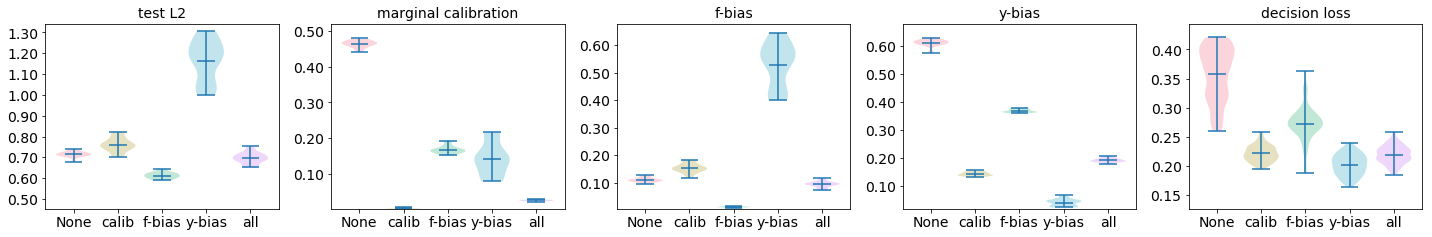

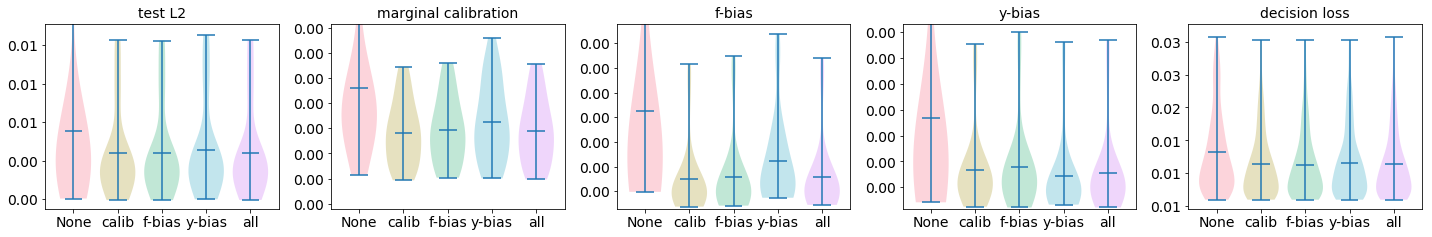

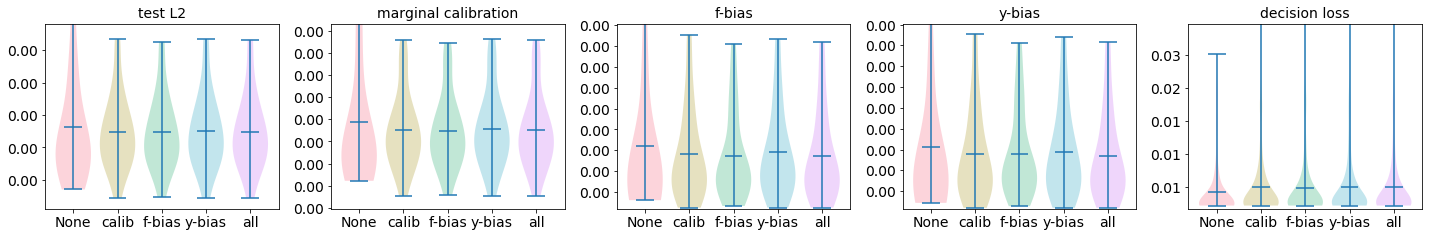

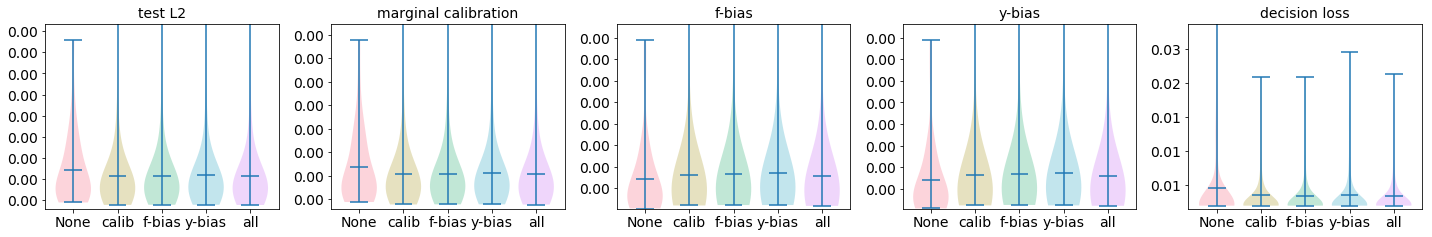

In [156]:
from matplotlib.ticker import FormatStrFormatter

names = ['train l2', 'test L2', 'y-bias', 'f-bias', 'marginal calibration', 'decision loss']
model_list = [2]
fontsize = 14

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')

    # ax.set_yticks([-0.1, 0.0, 0.1])
    # ax.set_ytick([-0.1, 0.0, 0.1], fontsize=fontsize)
#    ax.set_xlabel('Groups')

    # plt.gca().set_axis_style(fontsize=fontsize)
for mid in [0, 1, 2, 3]:
    # print(objectives.shape)
    palette = sns.color_palette('husl', 5)
    plt.figure(figsize=(20, 3.4))
    for idx, item in enumerate([1, 4, 3, 2, 5]):
        #for mid, model in enumerate(models):

        plt.subplot(1, 5, idx+1)
            #for i in range(5):
        if item != 5:
            datalist = objectives[mid, 8:, :, item].transpose(1, 0).reshape(-1, 5)
        else:
            datalist = (fps[mid, 8:, :, :].mean() + fns[mid, 8:, :, :]).transpose(1, 2, 0).reshape(-1, 5) 
            # print(datalist.shape)
        data_range = np.sort(datalist.flatten())
        data_range = [data_range[0] / 1.3, (data_range[-5] - data_range[0])*1.1 + data_range[0]]
        
        violin_parts = plt.violinplot(datalist, 
                       positions=range(5), 
                       widths=0.8, showmeans=True, showextrema=True)
        for vi, vp in enumerate(violin_parts['bodies']):
            vp.set_facecolor(palette[vi])
        
        labels = ['None', 'calib', 'f-bias', 'y-bias', 'all']
        plt.gca().set_xticks(np.arange(len(labels)))
        plt.gca().set_xticklabels(labels, fontsize=fontsize)
    
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        # plt.gca().set_yticks(np.linspace(data_range[0], data_range[1], 4))
        plt.yticks(fontsize=fontsize)
        plt.ylim(data_range)
        # plt.yscale('log')
            # plt.axvline(objectives[mid, 8+i, :, item].mean(), c=palette[i], label=labels[i], linewidth=2, alpha=0.6)
            # x_range = [objectives[mid, 8:, :, item].mean(axis=1).min(), objectives[mid, 8:, :, item].mean(axis=1).max()]
            # plt.xlim(x_range[0] - (x_range[1]-x_range[0]) * 0.1, x_range[1] + (x_range[1]-x_range[0]) * 0.1)
            # plt.legend()
            # plt.title('%s-%s' % (model, names[item]))
        plt.title(names[item], fontsize=fontsize)

    # plt.subplot(2, 3, 6)

    # plt.violinplot(datalist,                    
    #                positions=[(i//5)+(i%5)*0.1 for i in range(5*len(models))], 
    #                 widths=0.1, showmeans=True, showextrema=False)
    plt.tight_layout()
    plt.savefig('plots/decision_%s_%s.png' % (args.dataset, models[mid]))
    plt.show()